<font size=12px>Python script to build product system, compute LCA  </font>

This script blablabla .... 

<font size=2px>First, the import everything using the Import script & verify that the database are well loaded ! 
* Ecoinvent datasets (cut-off modelling) 
* ESA datasets
* Nyx Earth Life cycle modelling datasets

</font>

In [12]:
#### Lib Imports _ Please select a kernel with the latest version of olca IPC API  [TBVerified and replicated]
import pandas as pd
import numpy as np
import json
from tabulate import tabulate
import random as rand
from datetime import datetime, timedelta
import statistics as stats
import matplotlib as mp
import matplotlib.pyplot as plt
import scipy.stats as stat
#import olca as ipc (Old_version of Ipc API)
import olca_ipc as ipc
import olca_schema as o
import plotly.graph_objects as go
import nbformat as nb



from typing import Callable
###########################################################
client = ipc.Client(8080)
# OpenLCA IPC server Port
###########################################################

In [93]:
print("\nProduct Systems :")
for group_PS in client.get_all(o.ProductSystem):
    print(f"{group_PS.name} : {group_PS.target_amount} {group_PS.target_unit.name} ___ Version : {group_PS.version} Last Updt : {group_PS.last_change}" )

print("\nImpact Methods :")
for group_IM in client.get_descriptors(o.ImpactMethod):
    print(f"{group_IM.name} {group_IM.ref_type.name} :: {group_IM.id}")

print("\nPBS :")
for group_PBS in client.get_descriptors(o.Process):
    if group_PBS.category == "Nyx Earth PBS" : 
        print(f"{group_PBS.name} {group_PBS} :: {group_PBS.id}")


print("\nProcesses :")
for group_Proc in client.get_descriptors(o.Process):
    if group_Proc.category == "Nyx Earth" : 
        print(f"{group_Proc.name} {group_Proc} :: {group_Proc.id}")


Product Systems :
Power System : 1.0 Item(s) ___ Version : 00.00.000 Last Updt : 2023-11-27T15:41:26.156Z
Power System Assembly & Qualification : 1.0 Item(s) ___ Version : 00.00.000 Last Updt : 2023-11-28T09:42:33.673Z

Impact Methods :
Tests ImpactMethod :: ac3cd8bd-3c4a-425c-a25c-63b3eede91f8

PBS :
Battery Ref(id='ed53308d-d0fd-4d4b-85ba-896f2e1afbe0', category='Nyx Earth PBS', description=None, flow_type=<FlowType.PRODUCT_FLOW: 'PRODUCT_FLOW'>, location=None, name='Battery', process_type=<ProcessType.UNIT_PROCESS: 'UNIT_PROCESS'>, ref_unit=None, ref_type=<RefType.Process: 'Process'>) :: ed53308d-d0fd-4d4b-85ba-896f2e1afbe0
Control Unit Ref(id='58fd6ee5-43f8-4814-b188-d6b05a36158b', category='Nyx Earth PBS', description=None, flow_type=<FlowType.PRODUCT_FLOW: 'PRODUCT_FLOW'>, location=None, name='Control Unit', process_type=<ProcessType.UNIT_PROCESS: 'UNIT_PROCESS'>, ref_unit=None, ref_type=<RefType.Process: 'Process'>) :: 58fd6ee5-43f8-4814-b188-d6b05a36158b
Power System Ref(id='4

Create a Product System // Needs the root entity

<font size=3px>This method creates a product system for a given process. It recursively links the processes of that system according to the given linking configuration.

Linking config : https://greendelta.github.io/olca-schema/classes/LinkingConfig.html </font>

In [1]:
process_ref = client.find(o.Process, "Power System Assembly & Qualification")

config = o.LinkingConfig(
    prefer_unit_processes=True,
    provider_linking=o.ProviderLinking.PREFER_DEFAULTS,
)
system_ref = client.create_product_system(process_ref, config)

print(f"created product system {system_ref.name}, id = {system_ref.id}")

NameError: name 'client' is not defined

In [14]:
Product= "Power System Assembly & Qualification"
process_ref = client.find(o.Process, Product)
tobedeleted = client.find(o.ProductSystem, Product)

config = o.LinkingConfig(
    prefer_unit_processes=True,
    provider_linking=o.ProviderLinking.PREFER_DEFAULTS,
)
print(f"deleting product system {tobedeleted.name}, id = {tobedeleted.id}")
client.delete(tobedeleted)

system_ref = client.create_product_system(process_ref, config)

print(f"created product system {system_ref.name}, id = {system_ref.id}")

deleting product system Power System Assembly & Qualification, id = 9fb462a4-5db7-4a93-932d-7a35872e245c
created product system Power System Assembly & Qualification, id = 5fdebd17-0ce9-4f4f-8616-940885d8b284


In [15]:
### Check all the product system available
models = client.get_descriptors(o.ProductSystem)
for model in models: print(f"{model.name} :: {model.id}")
 
#### CHeck all the impact model available
print("\nImpact Methods")
methods = client.get_descriptors(o.ImpactMethod)
for method in methods: print(f"{method.name} :: {method.id}")

Power System :: c66c6ac0-144a-47f9-9efa-8c77bf517634
Power System Assembly & Qualification :: 5fdebd17-0ce9-4f4f-8616-940885d8b284

Impact Methods
Tests :: ac3cd8bd-3c4a-425c-a25c-63b3eede91f8


In [94]:
## Direct Selection 
LCA_Prod_syst = client.find (o.ProductSystem, name = "Power System")
LCA_Impact_method= client.find(o.ImpactMethod, name="Tests")
print (f"LCA Calculation of {LCA_Prod_syst.name} using the {LCA_Impact_method.name} assessment method\n")

# create a calculation setup
setup = o.CalculationSetup(
    target= LCA_Prod_syst,
    impact_method=LCA_Impact_method,
)

# run a calculation
client = ipc.Client()
result: ipc.Result = client.calculate(setup)

### Check if Any error
state = result.get_state()
if state.error:
    print(f"calculation failed: {state.error}")
    exit(-1)

# or better do this:
state = result.wait_until_ready()
print(f"result id: {state.id}\n","\nImpacts Results")
#client.put(o.Result(id=state.id,    flow_results=,    impact_method=,    impact_results=,    name=f"LCA results of {LCA_Prod_syst.name} using the {LCA_Impact_method.name} assessment method",product_system= ))

LCA_Impact_table = result.get_total_impacts()
for i in LCA_Impact_table:
    assert i.impact_category
    print(f"{i.impact_category.name} {i.amount} {i.impact_category.ref_unit}")


inventory = result.get_total_flows()
print("\n Inventory\n",
    pd.DataFrame(
        data=[
            (
                i.envi_flow.flow.name,
                i.envi_flow.is_input,
                i.amount,
                i.envi_flow.flow.ref_unit,
            )
            for i in inventory
        ],
        columns=["Env. Flow", "Is input?", "Amount", "Unit"],
    )
)



LCA Calculation of Power System using the Tests assessment method

result id: 2b68e5d9-f126-43d1-89f7-a7371db765c1
 
Impacts Results
Waste Production 142.402 kg
Global Warming 3185.36 kg C02-eq
Abiotic Ressource depletion 1184.3235 kg

 Inventory
    Env. Flow  Is input?     Amount Unit
0         Al       True    94.2005   kg
1      Fioul       True   949.1230   kg
2     Wastes      False   142.4020   kg
3        C02      False  3185.3600   kg
4   Plastics       True   141.0000   kg
5  Al _ Part       True    14.0000   kg


BE CAREFUL IT IS NOT YET POSSIBLE TO SAVE THE RESULT


In [95]:
# Setup our colours
coloring = ['black','LightSkyBlue','gold', 'olive','goldenrod','indianred','dimgrey','orangered','forestgreen','royalblue','mediumpurple','darkmagenta','darkcyan','saddlebrown']
alpha = 0.5

l_coloring = [f'rgb({(1 - alpha) * 255 + alpha * mp.colors.to_rgba(color,alpha=0.5)[0]*255},{(1 - alpha) * 255 + alpha * mp.colors.to_rgba(color,alpha=0.5)[1]*255},{(1 - alpha) * 255 + alpha * mp.colors.to_rgba(color,alpha=0.5)[2]*255})' for color in coloring]




print (l_coloring)
imp_cat_for_sankey = client.find(o.ImpactCategory,"Global Warming")

client = ipc.Client(8080)
# calculate a result for the default quantitative reference of a product system
result_sankey = client.calculate(
    o.CalculationSetup(
        target=LCA_Prod_syst,
        impact_method=LCA_Impact_method,
    )
)
state = result_sankey.wait_until_ready()

# get the Sankey graph for an impact category
g = result_sankey.get_sankey_graph(
    o.SankeyRequest(
        impact_category=imp_cat_for_sankey,
        max_nodes=20,
        min_share=0.05,
    )
)
print(f"loaded a graph with {len(g.nodes)} nodes and {len(g.edges)} edges")
# prints something like: loaded a graph with 10 nodes and 14 edges
tot_scaling = result_sankey.get_total_impact_value_of(imp_cat_for_sankey)

ref = client.put(o.Result(id=state.id))
# finally, dispose the result
result_sankey.dispose()



sorted_nodes = sorted(g.nodes, key=lambda n: n.index)

sorted_nodes_with_empty = []
idx = 0
for node in sorted_nodes :
    if idx != node.index : 
        sorted_nodes.insert(idx,node)
    idx=idx+1

#for node in sorted_nodes_with_empty : 
#   print (node.index,node.tech_flow.provider.name)
#print (tabulate(g.edges,headers="keys"))

#print ([node.tech_flow.provider.name for node in g.nodes])

node_mapping = {}
for node in g.nodes:
    node_mapping[node.index] = node.total_result
#print (node_mapping)
for edge in g.edges : 
    A = node_mapping.get(edge.provider_index)
   # print(A)

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=5,
        thickness=20,
        line=dict(color='white', width=1),
        color = coloring,
        label=[f"{node.tech_flow.provider.name}\n Direct: {node.direct_result:.2f} {imp_cat_for_sankey.ref_unit} _ Share : {node.direct_result/tot_scaling.amount*100 :.2f} % \nBurdens : {node.total_result-node.direct_result:.2f} {imp_cat_for_sankey.ref_unit} _ Share : {(node.total_result-node.direct_result)/tot_scaling.amount*100 :.2f} % " for node in sorted_nodes],
    ),
    link=dict(
        source=[edge.provider_index for edge in g.edges],
        target=[edge.node_index for edge in g.edges],
        value=[edge.upstream_share*(node_mapping.get(edge.provider_index)) for edge in g.edges],
        color=[l_coloring[edge.provider_index] for edge in g.edges],
        label= [f"{edge.upstream_share*(node_mapping.get(edge.provider_index)):.2f} {imp_cat_for_sankey.ref_unit}"for edge in g.edges]
    ),
    arrangement="snap",
    
))
fig.update_layout(
    hovermode='x',
    font=dict(size=10, color='dark gray'),
    paper_bgcolor='#F8F8ff'
)
fig.update_layout(title_text=f"Sankey Diagram of the {imp_cat_for_sankey.name} impacts for {model.name} process",  title_x=0.5)
# Display the plot
fig.show()





['rgb(127.5,127.5,127.5)', 'rgb(195.0,230.5,252.5)', 'rgb(255.0,235.0,127.5)', 'rgb(191.5,191.5,127.5)', 'rgb(236.5,210.0,143.5)', 'rgb(230.0,173.5,173.5)', 'rgb(180.0,180.0,180.0)', 'rgb(255.0,162.0,127.5)', 'rgb(144.5,197.0,144.5)', 'rgb(160.0,180.0,240.0)', 'rgb(201.0,183.5,237.0)', 'rgb(197.0,127.5,197.0)', 'rgb(127.5,197.0,197.0)', 'rgb(197.0,162.0,137.0)']
loaded a graph with 9 nodes and 8 edges


In [169]:
import graphviz
graph = graphviz.Digraph(format='png', graph_attr={'rankdir': 'LR'})
default_font_size = 14
for edge in g.edges:
    graph.edge(str(edge.provider_index), str(edge.node_index), 
                label=f"{edge.upstream_share*(node_mapping.get(edge.provider_index)):.2f} {imp_cat_for_sankey.ref_unit}",color=f'#000000{int(0.6*255):02X}',
                penwidth=str(edge.upstream_share*(node_mapping.get(edge.provider_index))/40),
                minlen="3",arrowhead="none", tailport = "e", headport= "c",
                )
    
for node in g.nodes:
    graph.node(f"{node.index}", 
                label = f'<<B><FONT POINT-SIZE="{default_font_size + 3}">{node.tech_flow.provider.name}<BR/></FONT></B>' \
                        f'Direct: {node.direct_result:.2f} {imp_cat_for_sankey.ref_unit} _ Share : {node.direct_result/tot_scaling.amount*100 :.2f} % <BR/>' \
                        f'Total : {node.total_result-node.direct_result:.2f} {imp_cat_for_sankey.ref_unit} _ Share : {(node.total_result-node.direct_result)/tot_scaling.amount*100 :.2f} % >', shape='box',
                        layer='1')

                    



# Save the graph to a file and optionally display it
graph.render(filename='sankey_graph', view=True)

'sankey_graph.png'

Attention Recalculer results

Text(0.5, 1.0, 'Share of burdens according to the impact category')

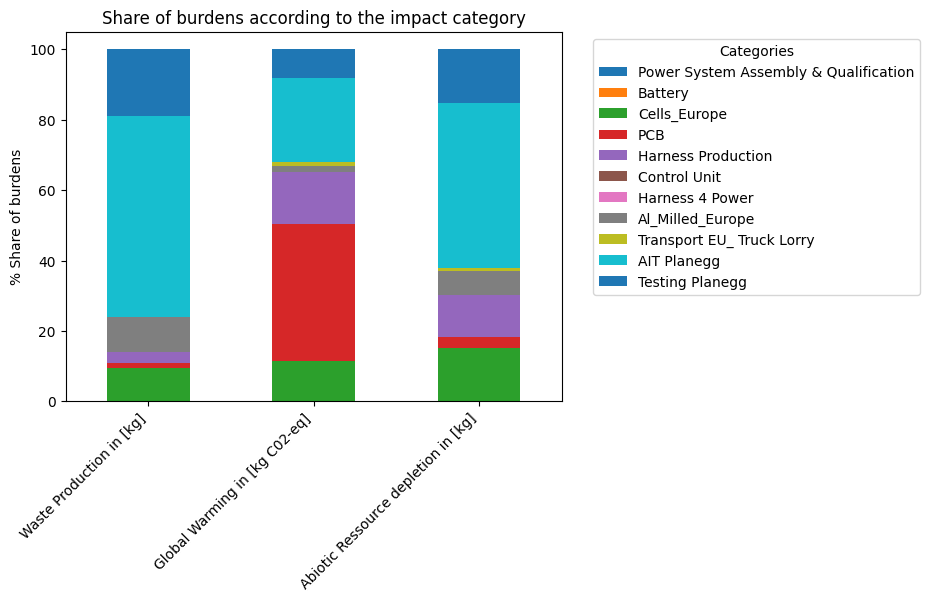

In [339]:
LCA_Impact_table = result.get_total_impacts()
A =[]
B= []

for A in result.get_tech_flows() : 
    B.append(A.provider.name)
#for i in LCA_Impact_table:
    #    impact_flow_contrib = result.get_impact_contributions_of(i.impact_category)
#  for x in impact_flow_contrib : 
#        A.append(x.amount/i.amount)



#B = ['Sandwich Package Production', 'Aluminium Foil Production', 'Electricity Production', 'Aluminium Production']
# Initialize an empty DataFrame with a single row
df = pd.DataFrame(columns=B)


for i in LCA_Impact_table:
    impact_flow_contrib = result.get_impact_contributions_of(i.impact_category)
    row_data = []
    for x in impact_flow_contrib:
        row_data.append(x.amount / i.amount*100)
    df.loc[f"{i.impact_category.name} in [{i.impact_category.ref_unit}]"] = row_data
    # Append the calculated values as a single row to the DataFrame
df.plot.bar(stacked=True)

plt.ylabel("% Share of burdens")
plt.xticks(rotation=45, ha="right")
plt.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Share of burdens according to the impact category')

Repartition according to a tag

In [340]:
tag_list = list(set(tag for A in result.get_tech_flows() for tag in client.get(o.Process, A.provider.id).tags))

print(tag_list)

['Power', 'Logistics', 'Equipment', 'Testing', 'Production', 'Spacecraft', 'Assembly', 'SubSystem']


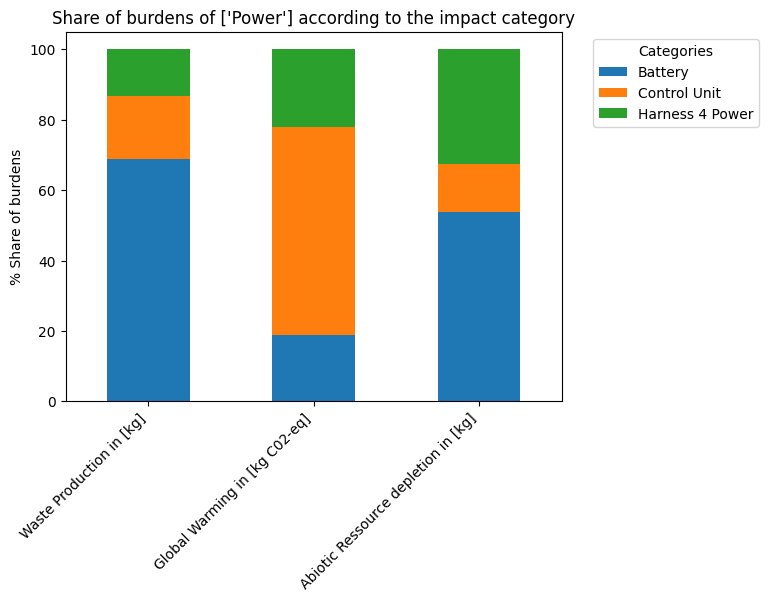

In [341]:
LCA_Impact_table = result.get_total_impacts()
chosen_tag = ["Power"]
B= []
C=[]
total_impact = 0 
for A in result.get_tech_flows() : 
    if any (item in chosen_tag for item in client.get(o.Process, A.provider.id).tags) : 
        B.append(A.provider.name)
        C.append(A)
       

#print (tabulate(LCA_Impact_table,headers="keys"))
# Initialize an empty DataFrame with a single row
df = pd.DataFrame(columns=B)


for i in LCA_Impact_table:
    impact_flow_contrib = result.get_impact_contributions_of(i.impact_category)
    total_impact = 0
    for a in C : 
        total_impact =total_impact+ result.get_total_impact_of(i.impact_category,a).amount
    row_data = []
    for x in impact_flow_contrib:
        if x.tech_flow.provider.name in B : 
            row_data.append(result.get_total_impact_of(i.impact_category,x.tech_flow).amount / total_impact*100)
    df.loc[f"{i.impact_category.name} in [{i.impact_category.ref_unit}]"] = row_data
    # Append the calculated values as a single row to the DataFrame
df.plot.bar(stacked=True)


plt.ylabel("% Share of burdens")
plt.xticks(rotation=45, ha="right")
plt.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f'Share of burdens of {chosen_tag} according to the impact category')

plt.show()


Life Cycle Repartition

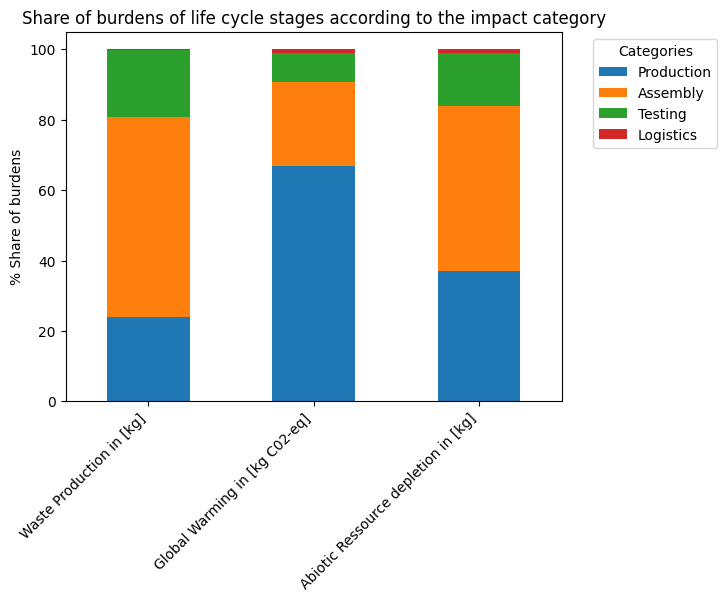

In [342]:
LCA_Impact_table = result.get_total_impacts()
life_cycle_tags = ["Production","Assembly","Testing","Logistics"]

C=[]

for A in result.get_tech_flows() : 
    if any (item in chosen_tag for item in client.get(o.Process, A.provider.id).tags) : 
        B.append(A.provider.name)
        C.append(A)
       

#print (tabulate(LCA_Impact_table,headers="keys"))
# Initialize an empty DataFrame with a single row
df = pd.DataFrame(columns=life_cycle_tags)


for i in LCA_Impact_table:
    impact_flow_contrib = result.get_impact_contributions_of(i.impact_category)
    row_data = []
    for item in life_cycle_tags:
        total_impact = 0 
        for A in result.get_tech_flows() : 
            if item in client.get(o.Process, A.provider.id).tags :
                total_impact =total_impact+ result.get_total_impact_of(i.impact_category,A).amount
        row_data.append(total_impact / i.amount*100)
    df.loc[f"{i.impact_category.name} in [{i.impact_category.ref_unit}]"] = row_data
    # Append the calculated values as a single row to the DataFrame
df.plot.bar(stacked=True)


plt.ylabel("% Share of burdens")
plt.xticks(rotation=45, ha="right")
plt.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f'Share of burdens of life cycle stages according to the impact category')

plt.show()
